In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
gpath='/content/gdrive/My Drive/Findit/Death Valley/'
glocal='/content/gdrive/My Drive/Findit_local/'

In [0]:
#It's needed for the visualization
!pip uninstall keras-vis -y
!pip install git+https://github.com/raghakot/keras-vis.git
!pip install --upgrade scikit-image

Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-goqigqq3
  Stored in directory: /tmp/pip-ephem-wheel-cache-eyo7iqk_/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.14.2)


In [0]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, image, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from numpy.random import seed
from tensorflow import set_random_seed
from IPython.display import Image
from keras.optimizers import Adam

import imageio as io
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from vis.visualization import visualize_activation,visualize_cam, overlay
import matplotlib.cm as cm

import os
import tensorflow as tf

Using TensorFlow backend.


In [0]:
mobile = keras.applications.mobilenet.MobileNet()
seed(1)#to have reproducible results
set_random_seed(2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [0]:
#base_model=MobileNet(weights='imagenet',include_top=False, input_shape = (224, 224, 3)) #imports the mobilenet model and discards the last 1000 neuron layer.
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (224, 224, 3))

x=base_model.output
#x = Flatten()(x)
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
x=Dense(256,activation='relu')(x)
x=Dense(124,activation='relu')(x)
x = Dropout(0.3)(x)
preds=Dense(49,activation='softmax', name='predictions')(x) #final layer with softmax activation

In [0]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [0]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
#freeze original mobilenet layers 
for layer in base_model.layers:
  #if layer.name == 'conv_pw_12_relu':#mobilenet
  if layer.name == 'conv2d_88':#inception     
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' frozen.')

Capa input_2 frozen.
Capa conv2d_1 frozen.
Capa batch_normalization_1 frozen.
Capa activation_1 frozen.
Capa conv2d_2 frozen.
Capa batch_normalization_2 frozen.
Capa activation_2 frozen.
Capa conv2d_3 frozen.
Capa batch_normalization_3 frozen.
Capa activation_3 frozen.
Capa max_pooling2d_1 frozen.
Capa conv2d_4 frozen.
Capa batch_normalization_4 frozen.
Capa activation_4 frozen.
Capa conv2d_5 frozen.
Capa batch_normalization_5 frozen.
Capa activation_5 frozen.
Capa max_pooling2d_2 frozen.
Capa conv2d_9 frozen.
Capa batch_normalization_9 frozen.
Capa activation_9 frozen.
Capa conv2d_7 frozen.
Capa conv2d_10 frozen.
Capa batch_normalization_7 frozen.
Capa batch_normalization_10 frozen.
Capa activation_7 frozen.
Capa activation_10 frozen.
Capa average_pooling2d_1 frozen.
Capa conv2d_6 frozen.
Capa conv2d_8 frozen.
Capa conv2d_11 frozen.
Capa conv2d_12 frozen.
Capa batch_normalization_6 frozen.
Capa batch_normalization_8 frozen.
Capa batch_normalization_11 frozen.
Capa batch_normalization_

In [0]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                 validation_split=0.3,
                                 fill_mode='nearest',
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    zoom_range=0.1,  # set range for random zoom
    horizontal_flip=True)  # randomly flip images
train_generator=train_datagen.flow_from_directory(gpath+'MobileNetData',   
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=128,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 seed=1,
                                                 #save_to_dir=glocal #saves augmented pictures to local
                                                 )

test_datagen = ImageDataGenerator()
test_generator=test_datagen.flow_from_directory(gpath+'test/',   
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=128,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 seed=1)


Found 519 images belonging to 49 classes.
Found 57 images belonging to 12 classes.


In [0]:
print(train_generator.n,train_generator.batch_size,train_generator.n//train_generator.batch_size)

519 128 4


In [0]:
%%time
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
history=model.fit_generator(generator=train_generator
                   ,steps_per_epoch=step_size_train
                    #validation_data=test_generator, validation_steps=step_size_train, #error indicates that number of classes in train and test folder are different
                   ,epochs=100
                    ,workers=8)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4/4 [==============================] - 39s 10s/step - loss: 3.8365 - acc: 0.0586
Epoch 2/100
4/4 [==============================] - 3s 698ms/step - loss: 3.6021 - acc: 0.0892
Epoch 3/100
4/4 [==============================] - 2s 554ms/step - loss: 3.2845 - acc: 0.1369
Epoch 4/100
4/4 [==============================] - 16s 4s/step - loss: 2.8855 - acc: 0.2220
Epoch 5/100
4/4 [==============================] - 10s 3s/step - loss: 2.8015 - acc: 0.2718
Epoch 6/100
4/4 [==============================] - 9s 2s/step - loss: 2.3148 - acc: 0.3613
Epoch 7/100
4/4 [==============================] - 10s 2s/step - loss: 2.1940 - acc: 0.3920
Epoch 8/100
4/4 [==============================] - 12s 3s/step - loss: 2.0559 - acc: 0.4211
Epoch 9/100
4/4 [==============================] - 14s 3s/step - loss: 2.0086 - acc: 0.4481
Epoch 10/100
4/4 [==============================] - 3s 646ms/step - loss: 1.8538 - acc: 0.4814
Epoch 11/100
4/4 [=======

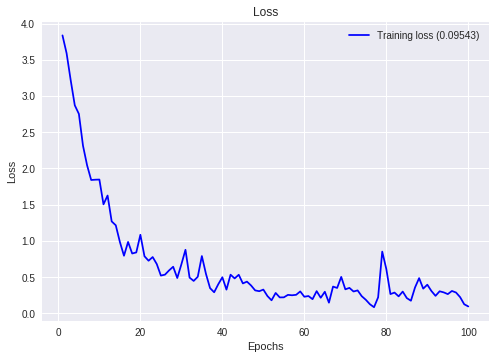

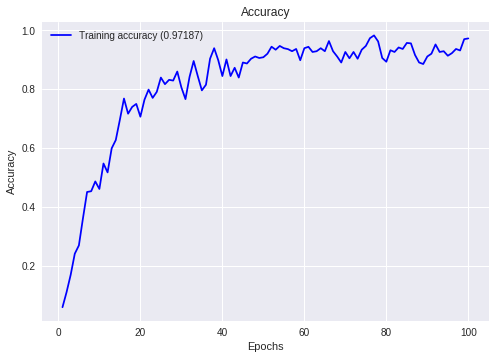

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

In [0]:
#save model in disk
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open(glocal+'modelv17.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(glocal+'modelv17.h5')
print("Saved model to disk")

Saved model to disk


In [0]:
%%time
#load model from disk
from keras.models import model_from_json
# load json and create model
json_file = open(glocal+'modelv17.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(glocal+'modelv17.h5')
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
print("Loaded model from disk")

In [0]:
print(model.summary())

In [0]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [0]:
#Classes
label_map_rev = (train_generator.class_indices)
label_map=dict((v,k) for k,v in label_map_rev.items())#
label_map

In [0]:
def find_it_predict(model, test_image_path, actual_class, prediction_layer):
  loaded_image = load_image(test_image_path)

  pred = model.predict(loaded_image)
  y_classes=np.argmax(pred)
  prob=max(pred[0])
  img=utils.load_img(test_image_path, target_size=(224, 224))

  plt.imshow(img)
  plt.axis('off')
  print('Prediction: {} (class {}) with a probability of {:.3f}'.format(label_map[y_classes],y_classes,prob))
  print('Actual: {} (class {})'.format(label_map[actual_class],actual_class))

In [0]:
def find_it_activation(model, test_image_path, actual_class, prediction_layer):
  #functions to find where the algorithm is watching to see the prediction
  loaded_image = load_image(test_image_path)
  img=utils.load_img(test_image_path, target_size=(224, 224))
  #index of predictions layer
  layer_idx = utils.find_layer_idx(model, prediction_layer)
  print('Número de capa: ', layer_idx)
  
  #visualize activation
  img1 = visualize_activation(model, layer_idx , filter_indices=actual_class, max_iter=200, verbose=False)
  
  #visualize-saliency
  grads = visualize_saliency(model, layer_idx, filter_indices=actual_class, seed_input=img, backprop_modifier='relu')
  
  #charts activation and saliency
  #plt.rcParams['figure.figsize'] = (18, 6) # tamaño de las imágenes
  f, ax = plt.subplots(1, 5, figsize=(40,10))
  ax[0].imshow(img1)
  ax[0].grid(False)
  ax[1].imshow(grads, cmap='jet')
  ax[1].grid(False)
 
  #visualize cam-saliency
  j=2
  for modifier in [None, 'guided', 'relu']:
    plt.suptitle('vanilla' if modifier is None else modifier)
    grads = visualize_cam(model, layer_idx, filter_indices=actual_class, 
                          seed_input=img, backprop_modifier=modifier)        
    # convert image to 3d to show it
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    ax[j].imshow(overlay(jet_heatmap, img))
    ax[j].axis('off')
    j=j+1

In [0]:
###data to enter in prediction and visualization code
#image_path=gpath+'test/badger/v4BMNGw.jpg'   #test picture
#mage_path=gpath+'test/MOUNTAIN BLUEBIRD/images (2).jpg'   #test picture
#image_path=gpath+'test/MOUNTAIN BLUEBIRD/images (3).jpg'   #test picture
image_path=gpath+'test/verbena/images (1).jpg'   #test picture
#image_path=gpath+'/train/Animals/black-tailed jackrabbit/02-Blacktailed_jackrabbit-02-Extra-Photo.jpeg'   #train picture
animal_class=47 #filled by hand
layer_name='predictions'
layer_index = utils.find_layer_idx(model, layer_name)

In [0]:
%%time
find_it_predict(model, image_path,animal_class,layer_name)

In [0]:
%%time
# Swap softmax with linear
model.layers[layer_index].activation = activations.linear
#model.layers[layer_index].activation = activations.relu  #doesn't work to correct the predictions
model = utils.apply_modifications(model)

In [0]:
%%time
find_it_activation(model, image_path,animal_class,layer_name)

In [0]:
%%time
# Swap back to softmax with linear
model.layers[layer_index].activation = activations.softmax
model = utils.apply_modifications(model)

In [0]:
def find_it_validate(model, test_image_path, actual_class_label, prediction_layer):
  number_true=0
  number_unknown=0 #such as AMERICAN ROBIN which doesn't exist in MobileNetData folder
  number_wrong=0
  i=0
  wrongly_identified=[]
  
  for file in test_image_path:
    loaded_image = load_image(file)
    pred = model.predict(loaded_image)
    y_classes=np.argmax(pred)
    prob=max(pred[0])

    print('File: {}\nPrediction: {}, probability of {:.3f}, \nactual:     {}\n'.format(file,label_map[y_classes],prob,actual_class_label[i]))
    if label_map[y_classes]==actual_class_label[i]:
      number_true=number_true+ 1
    elif actual_class_label[i] not in label_map_rev: 
      number_unknown=number_unknown+1
    else:
      number_wrong=number_wrong+1 
      wrongly_identified.append(file)
    i=i+1
  print('\nImages checked: {}\nCorrectly predicted: {}\nNumber wrong: {}\nNumber clases not available in training: {}\n% accuracy: {}'.format(len(test_files_class),
                                                                                                                     number_true, number_wrong,number_unknown,number_true/(len(test_files_class)-number_unknown)))
  print('Images wrongly identified: ',wrongly_identified)

In [0]:
#define list of test files and actual classes
import os
test_files=[os.path.join(path, name) for path, subdirs, files in os.walk(gpath+'test/') for name in files]
test_classes=[i.split('/')[-2] for i in test_files]
test_files_class=list(zip(test_files,test_classes))

In [0]:
###data to enter in prediction and visualization code
layer_name='predictions'
layer_index = utils.find_layer_idx(model, layer_name)

In [0]:
find_it_validate(model, test_files,test_classes,layer_name)

In [0]:
#MissingClasses in training
missing_classes_check= train_datagen.flow_from_directory(gpath+'test', batch_size=512, seed=1234)
missing_classes_check = (missing_classes_check.class_indices)
for i in missing_classes_check:
  if i not in label_map_rev:
    print(i)

In [0]:
len(missing_classes_check)

In [0]:
img=utils.load_img(image_path, target_size=(224, 224))
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
n_augmentations = 8

plt.figure(figsize=(15, 6))    
i = 0

for batch in train_datagen.flow(img, 
                          batch_size=1, 
                          seed=21, 
                          save_to_dir=glocal, 
                          save_prefix="hydrant", 
                          save_format="jpeg"):
    
    plt.subplot(2, int(np.ceil(n_augmentations * 1. / 2)), i + 1)
    plt.imshow(array_to_img(batch[0]))
    plt.axis("off")
    
    i += 1
    if i >= n_augmentations:
        break